## Model 2 Evaluation
Model 2:
- Author
- Clinical history
- Cleaned data

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openai
from openai import OpenAI

In [5]:
fp = 'model2_output.jsonl'
response = []

with open(fp, 'r') as file:
    for line in file:
        line = json.loads(line)
        response.append({'id': line.get('question_id', None), 'prompt': line.get('prompt', None), 'output': line.get('text', None)})

In [6]:
response_df = pd.DataFrame(response)
response_df.head()

,id,prompt,output
0,Asketar_50018904.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Hypoxi...",FINDINGS: See impression. Signed b...
1,Tongumib_50019069.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Shortn...",FINDINGS: See impression. Signed b...
2,Howecuch_50020873.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Chest ...",FINDINGS: See impression.\n\n\n\n\n*\n\nSigned...
3,Runusuf_50106449.jpg,"AUTHOR: Brouha, Sharon CLINICAL HISTORY: Possi...",FINDINGS: See IMPRESSION.\n\n\n\n\n*\n\nSigned...
4,Fikecri_50149298.jpg,"AUTHOR: Jacobs, Kathleen CLINICAL HISTORY: Pos...",FINDINGS: See impression Signed by...


In [7]:
# response_df['output'][5]
# pd.isnull(response_df['output']).sum()
len(response_df)

2247

In [43]:
model2_df = pd.read_csv('Data/model2_results.csv')
model2_df.head()

,id,phonetic_id,author,clinical_history,llava_findings,llava_impression,llava_report,radiologist_report,radiologist_findings,radiologist_impression,similarity,impression_similarity,findings_similarity,is_si_l,is_si_r,lf_len,li_len,rf_len,ri_len
0,54059849,Abifel,"Jacobs, Kathleen",Chest pain\nCONTEXT: Outpatient\nAGE: 69\nSEX:...,Lungs are well expanded and clear. No pleural ...,No acute findings. No radiographic evidence of...,FINDINGS:\nLungs are well expanded and clear. ...,FINDINGS: Lungs are well expanded and clear....,Lungs are well expanded and clear. No pleural ...,NaN,0.766498,-0.016392,0.940764,False,False,172,70,232,0
1,53428634,Aburik,"Hahn, Lewis",Status post placement of venous line\nCONTEXT:...,Lines and Tubes: Interval placement of a right...,Right upper extremity PICC terminates in the l...,FINDINGS:\nLines and Tubes: Interval placement...,FINDINGS: Lines and Tubes: Right upper ext...,Lines and Tubes: Right upper extremity PICC te...,NaN,0.915866,0.030469,0.900651,False,False,294,55,371,0
2,53439132,Achoroos,"Smitaman, Edward",Shortness breath\nCONTEXT: Inpatient\nAGE: 55\...,Please see Impression.,No acute pulmonary abnormality. No signific...,FINDINGS:\nPlease see Impression.\n\nIMPRESSIO...,FINDINGS: Lines and Tubes: None Mediastin...,Lines and Tubes: None Mediastinum: The cardio...,NaN,0.689163,-0.007628,0.029136,True,False,22,83,363,0
3,50219723,Ackoofdek,"Wyatt, Alvin",Chest pain,See impression.,Redemonstration of a right-sided PICC line wit...,FINDINGS:\nSee impression.\n\nIMPRESSION: Rede...,FINDINGS: \nSee impression\n\nIMPRESSION: ...,See impression,Exam is somewhat limited by patient body habit...,0.592625,0.480963,0.917290,True,True,15,169,14,313
4,52165792,Adefoup,"Weihe, Elizabeth",Shortness of breath,Unknown,Unknown,FINDINGS:\nUnknown\n\nIMPRESSION: Unknown,FINDINGS: None,NaN,NaN,0.601762,0.154442,0.340089,True,False,7,7,4,0


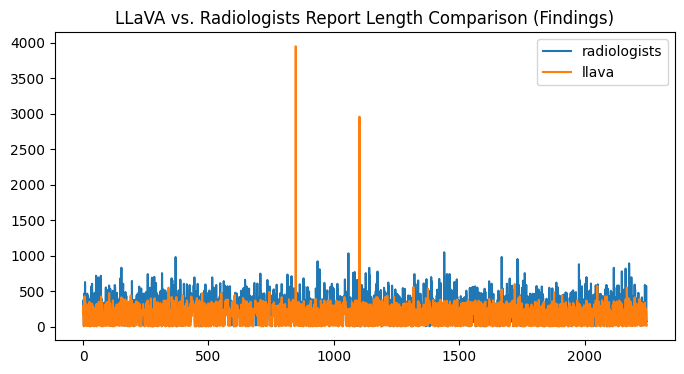

In [68]:
plt.figure(figsize=(8, 4))
plt.title('LLaVA vs. Radiologists Report Length Comparison (Findings)')
plt.plot(model2_df['rf_len'], label='radiologists')
plt.plot(model2_df['lf_len'], label='llava')
plt.legend()
# llava generates shorter reports on average, but is expected

##### Drop reports with no mentions of any disease with NLP first before calling the API - saves tokens

In [21]:
diseases = {
    'pneumothorax': ["none", "small", "medium", "large", "unknown"],
    'pneumonia': ["none", "possible", "definite", "unknown"],
    'pleural effusion': ["none", "small", "medium", "large", "unknown"],
    'cardiomegaly': ["normal", "mild", "severe", "unknown"],
    'edema': ["none", "mild", "moderate", "severe", "unknown"],
    'rib fracture': ["none", "present", "unknown"]
}

In [25]:
mask = response_df['output'].apply(lambda x: any(disease in x.lower() for disease in diseases.keys()))
filtered_df = response_df[mask]
filtered_df.shape

(1633, 3)

##### Testing a single case

In [78]:
print(model2_df['llava_report'][12])

FINDINGS:
See impression

IMPRESSION: Stable tracheostomy tube, feeding tube with tip outside the field of view.    Increased conspicuity of a small right apical pneumothorax measuring 1.4 cm, previously 1.2 cm.    No other change.


In [34]:
report = response_df.iloc[15, 2]

new_prompt = f"Given this report: '{report}', classify the severity of each condition. Classify as 'unknown' if a condition is not explicitly mentioned. Return the results in a dictionary format. The conditions and their possible severities are:\
- Pneumothorax: none, small, medium, large, unknown\
- Pneumonia: none, possible, definite, unknown\
- Pleural effusion: none, small, medium, large, unknown\
- Cardiomegaly: normal, mild, severe, unknown\
- Edema: none, mild, moderate, severe, unknown\
- Rib fracture: none, present, unknown"\

print(new_prompt)

Given this report: 'FINDINGS: See impression             Signed by: Jacobs, Kathleen 02/10/2021 09:47:29IMPRESSION: Stable appearance of the chest compared to 1/26/2021. No evidence of pneumonia.', classify the severity of each condition. Classify as 'unknown' if a condition is not explicitly mentioned. Return the results in a dictionary format. The conditions and their possible severities are:- Pneumothorax: none, small, medium, large, unknown- Pneumonia: none, possible, definite, unknown- Pleural effusion: none, small, medium, large, unknown- Cardiomegaly: normal, mild, severe, unknown- Edema: none, mild, moderate, severe, unknown- Rib fracture: none, present, unknown


In [79]:
# Testing
client = OpenAI(api_key='')
report = model2_df['llava_report'][12]
new_prompt = f"Given this report: '{report}', classify the severity of each condition. Classify as unknown if not mentioned. Return the results in a dictionary. The conditions and their possible severities are:\
- Pneumothorax: none, small, medium, large, unknown\
- Pneumonia: none, possible, definite, unknown\
- Pleural effusion: none, small, medium, large, unknown\
- Cardiomegaly: normal, mild, severe, unknown\
- Edema: none, mild, moderate, severe, unknown\
- Rib fracture: none, present, unknown"\

response = client.chat.completions.create(
  model="gpt-3.5-turbo-0125",
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to parse medical reports."},
    {"role": "user", "content": new_prompt}
  ]
)
print(response.choices[0].message.content)
response_content = response.choices[0].message.content

{
    "Pneumothorax": "small",
    "Pneumonia": "unknown",
    "Pleural effusion": "unknown",
    "Cardiomegaly": "unknown",
    "Edema": "unknown",
    "Rib fracture": "unknown"
}


In [87]:
type(eval(response_content))

dict

In [2]:
diseases = {
    'pneumothorax': ["none", "small", "medium", "large", "unknown"],
    'pneumonia': ["none", "possible", "definite", "unknown"],
    'pleural effusion': ["none", "small", "medium", "large", "unknown"],
    'cardiomegaly': ["normal", "mild", "severe", "unknown"],
    'edema': ["none", "mild", "moderate", "severe", "unknown"],
    'rib fracture': ["none", "present", "unknown"]
}
disease_classifications = {disease: [] for disease in diseases}

questions = []
for disease, scales in diseases.items():
    scale_str = ', '.join(scales)
    questions.append(f"Determine the severity of {disease}: {scale_str}.")
questions_str = ' '.join(questions)
questions_str

'Determine the severity of pneumothorax: none, small, medium, large, unknown. Determine the severity of pneumonia: none, possible, definite, unknown. Determine the severity of pleural effusion: none, small, medium, large, unknown. Determine the severity of cardiomegaly: normal, mild, severe, unknown. Determine the severity of edema: none, mild, moderate, severe, unknown. Determine the severity of rib fracture: none, present, unknown.'

##### Call ChatGPT 3.5 Turbo

In [95]:
client = OpenAI(api_key='')

def get_classifications(df, col, questions_str):
  classifications = []

  # API call for each report
  for report in df[col]:
    response = client.chat.completions.create(
      model="gpt-3.5-turbo-0125",
      messages=[
        {"role": "system", "content": "You are a helpful assistant designed to parse medical reports."},
        {"role": "user", "content": f"Given this report: {report} {questions_str}"}
      ]
    )
    classifications.append(response.choices[0].message.content)

  return classifications


In [114]:
questions_str = "Classify the severity of each condition. Classify as unknown if not mentioned. Return the results in a dictionary. The conditions and their possible severities are:\
- Pneumothorax: none, small, medium, large, unknown\
- Pneumonia: none, possible, definite, unknown\
- Pleural effusion: none, small, medium, large, unknown\
- Cardiomegaly: normal, mild, severe, unknown\
- Edema: none, mild, moderate, severe, unknown\
- Rib fracture: none, present, unknown"

radiologist_report = get_classifications(eval_df, 'radiologist_report', questions_str)
radiologist_report

['{\n    "Pneumothorax": "none",\n    "Pneumonia": "none",\n    "Pleural effusion": "none",\n    "Cardiomegaly": "normal",\n    "Edema": "none",\n    "Rib fracture": "none"\n}',
 'Here is the classification of severity for each condition mentioned in the report:\n\n1. Pneumothorax: None\n2. Pneumonia: None\n3. Pleural Effusion: None\n4. Cardiomegaly: Unknown\n5. Edema: Unknown\n6. Rib Fracture: Unknown\n\nPlease let me know if you need any further assistance.',
 '{\n  "Pneumothorax": "none",\n  "Pneumonia": "none",\n  "Pleural effusion": "none",\n  "Cardiomegaly": "normal",\n  "Edema": "none",\n  "Rib fracture": "none"\n}',
 '{\n  "Pneumothorax": "none",\n  "Pneumonia": "possible",\n  "Pleural effusion": "none",\n  "Cardiomegaly": "normal",\n  "Edema": "none",\n  "Rib fracture": "none"\n}',
 '{\n  "Pneumothorax": "none",\n  "Pneumonia": "unknown",\n  "Pleural effusion": "none",\n  "Cardiomegaly": "unknown",\n  "Edema": "none",\n  "Rib fracture": "unknown"\n}',
 '{\n    "Pneumothorax": 

In [137]:
temp = eval_df['llava_parsed'].apply(lambda x: eval(x) if x.strip().startswith('{') else x)
[item for item in temp if not isinstance(item, dict)]


["```python\n{\n    'Pneumothorax': 'none',\n    'Pneumonia': 'none',\n    'Pleural effusion': 'none',\n    'Cardiomegaly': 'normal',\n    'Edema': 'none',\n    'Rib fracture': 'none'\n}\n```",
 "Based on the given report, all findings are marked as unknown. Therefore, the severity of each condition will be classified as unknown. Here are the results in dictionary format:\n\n```python\n{\n    'Pneumothorax': 'unknown',\n    'Pneumonia': 'unknown',\n    'Pleural effusion': 'unknown',\n    'Cardiomegaly': 'unknown',\n    'Edema': 'unknown',\n    'Rib fracture': 'unknown'\n}\n```",
 'Based on the information provided in the report, the severity classification for each condition is as follows:\n\n1. Pneumothorax: small\n2. Pneumonia: unknown\n3. Pleural effusion: unknown\n4. Cardiomegaly: unknown\n5. Edema: none\n6. Rib fracture: none\n\nHere is the result in dictionary format:\n\n```json\n{\n    "Pneumothorax": "small",\n    "Pneumonia": "unknown",\n    "Pleural effusion": "unknown",\n   

In [113]:
# eval_df.to_csv('raw_llava_parsed.csv')
eval_df = pd.read_csv('raw_llava_parsed.csv')
eval_df.head()

,Unnamed: 0,id,phonetic_id,author,clinical_history,llava_report,radiologist_report,llava_parsed
0,0,54059849,Abifel,"Jacobs, Kathleen",Chest pain\nCONTEXT: Outpatient\nAGE: 69\nSEX:...,FINDINGS:\nLungs are well expanded and clear. ...,FINDINGS: Lungs are well expanded and clear....,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""..."
1,1,53428634,Aburik,"Hahn, Lewis",Status post placement of venous line\nCONTEXT:...,FINDINGS:\nLines and Tubes: Interval placement...,FINDINGS: Lines and Tubes: Right upper ext...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""..."
2,2,53439132,Achoroos,"Smitaman, Edward",Shortness breath\nCONTEXT: Inpatient\nAGE: 55\...,FINDINGS:\nPlease see Impression.\n\nIMPRESSIO...,FINDINGS: Lines and Tubes: None Mediastin...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""..."
3,3,50219723,Ackoofdek,"Wyatt, Alvin",Chest pain,FINDINGS:\nSee impression.\n\nIMPRESSION: Rede...,FINDINGS: \nSee impression\n\nIMPRESSION: ...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""..."
4,4,52165792,Adefoup,"Weihe, Elizabeth",Shortness of breath,FINDINGS:\nUnknown\n\nIMPRESSION: Unknown,FINDINGS: None,"{\n 'Pneumothorax': 'unknown',\n 'Pneumo..."


#### Original Report

In [11]:
report_classifications = get_classifications(response_df, 'output', questions_str)
report_classifications

['- Pneumothorax: None\n- Pneumonia: Possible\n- Pleural effusion: None\n- Cardiomegaly: None\n- Edema: None\n- Rib fracture: Present',
 'Chest: Stable\nInterstitial edema: Stable\nPneumothorax: None\nPneumonia: Possible\nPleural effusion: None\nCardiomegaly: None\nEdema: None\nRib fracture: Present',
 '- Pneumothorax: None\n- Pneumonia: Possible\n- Pleural effusion: None\n- Cardiomegaly: None\n- Edema: None\n- Rib fracture: Present',
 '- Pneumothorax: None\n- Pneumonia: Possible\n- Pleural effusion: None\n- Cardiomegaly: None\n- Edema: None\n- Rib fracture: Present',
 'Pneumothorax: none\nPneumonia: possible\nPleural effusion: none\nCardiomegaly: none\nEdema: none\nRib fracture: present',
 'Pneumothorax: none\nPneumonia: possible\nPleural effusion: none\nCardiomegaly: none\nEdema: none\nRib fracture: none',
 '- Pneumothorax: none\n- Pneumonia: possible\n- Pleural effusion: none\n- Cardiomegaly: none\n- Edema: none\n- Rib fracture: present',
 'Severity of pneumothorax: None  \nSeverity

In [13]:
# response_df['output_classes'] = report_classifications
response_df.head()

,id,prompt,output,output_classes
0,Asketar_50018904.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Hypoxi...",FINDINGS: See impression. Signed b...,- Pneumothorax: None\n- Pneumonia: Possible\n-...
1,Tongumib_50019069.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Shortn...",FINDINGS: See impression. Signed b...,Chest: Stable\nInterstitial edema: Stable\nPne...
2,Howecuch_50020873.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Chest ...",FINDINGS: See impression.\n\n\n\n\n*\n\nSigned...,- Pneumothorax: None\n- Pneumonia: Possible\n-...
3,Runusuf_50106449.jpg,"AUTHOR: Brouha, Sharon CLINICAL HISTORY: Possi...",FINDINGS: See IMPRESSION.\n\n\n\n\n*\n\nSigned...,- Pneumothorax: None\n- Pneumonia: Possible\n-...
4,Fikecri_50149298.jpg,"AUTHOR: Jacobs, Kathleen CLINICAL HISTORY: Pos...",FINDINGS: See impression Signed by...,Pneumothorax: none\nPneumonia: possible\nPleur...


In [30]:
response_df['output_classes'][15]

'- Pneumothorax: none\n- Pneumonia: none\n- Pleural effusion: none\n- Cardiomegaly: none\n- Edema: none\n- Rib fracture: present'

In [33]:
response_df['output_classes'].str.contains('Rib fracture: present').sum()

311

In [38]:
def str_to_list(text):
    lst = text.replace('\n\n', '\n').split('\n')
    return [i.split(': ')[-1] for i in lst]

response_df['output_classes_lst'] = response_df['output_classes'].apply(str_to_list)
response_df.head()

,id,prompt,output,output_classes,output_classes_lst
0,Asketar_50018904.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Hypoxi...",FINDINGS: See impression. Signed b...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]"
1,Tongumib_50019069.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Shortn...",FINDINGS: See impression. Signed b...,Chest: Stable\nInterstitial edema: Stable\nPne...,"[Stable, Stable, None, Possible, None, None, N..."
2,Howecuch_50020873.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Chest ...",FINDINGS: See impression.\n\n\n\n\n*\n\nSigned...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]"
3,Runusuf_50106449.jpg,"AUTHOR: Brouha, Sharon CLINICAL HISTORY: Possi...",FINDINGS: See IMPRESSION.\n\n\n\n\n*\n\nSigned...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]"
4,Fikecri_50149298.jpg,"AUTHOR: Jacobs, Kathleen CLINICAL HISTORY: Pos...",FINDINGS: See impression Signed by...,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, present]"


In [40]:
# drop rows with more than 6 diseases classified
response_df = response_df.loc[(response_df['output_classes_lst'].str.len() == 6)]
response_df.head()

,id,prompt,output,output_classes,output_classes_lst
0,Asketar_50018904.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Hypoxi...",FINDINGS: See impression. Signed b...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]"
2,Howecuch_50020873.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Chest ...",FINDINGS: See impression.\n\n\n\n\n*\n\nSigned...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]"
3,Runusuf_50106449.jpg,"AUTHOR: Brouha, Sharon CLINICAL HISTORY: Possi...",FINDINGS: See IMPRESSION.\n\n\n\n\n*\n\nSigned...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]"
4,Fikecri_50149298.jpg,"AUTHOR: Jacobs, Kathleen CLINICAL HISTORY: Pos...",FINDINGS: See impression Signed by...,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, present]"
5,Belido_50166195.jpg,"AUTHOR: Curtis, Brian CLINICAL HISTORY: Shortn...",FINDINGS: See impressionIMPRESSION: No signifi...,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]"


In [42]:
keys = list(diseases.keys())
for i in range(len(keys)):
    response_df[f'output_{keys[i]}'] = response_df['output_classes_lst'].apply(lambda x: x[i])
response_df.head()

/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_88971/1070572736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_df[f'output_{keys[i]}'] = response_df['output_classes_lst'].apply(lambda x: x[i])
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_88971/1070572736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_df[f'output_{keys[i]}'] = response_df['output_classes_lst'].apply(lambda x: x[i])
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_88971/107057273

,id,prompt,output,output_classes,output_classes_lst,output_pneumothorax,output_pneumonia,output_pleural effusion,output_cardiomegaly,output_edema,output_rib fracture
0,Asketar_50018904.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Hypoxi...",FINDINGS: See impression. Signed b...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]",None,Possible,None,None,None,Present
2,Howecuch_50020873.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Chest ...",FINDINGS: See impression.\n\n\n\n\n*\n\nSigned...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]",None,Possible,None,None,None,Present
3,Runusuf_50106449.jpg,"AUTHOR: Brouha, Sharon CLINICAL HISTORY: Possi...",FINDINGS: See IMPRESSION.\n\n\n\n\n*\n\nSigned...,- Pneumothorax: None\n- Pneumonia: Possible\n-...,"[None, Possible, None, None, None, Present]",None,Possible,None,None,None,Present
4,Fikecri_50149298.jpg,"AUTHOR: Jacobs, Kathleen CLINICAL HISTORY: Pos...",FINDINGS: See impression Signed by...,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, present]",none,possible,none,none,none,present
5,Belido_50166195.jpg,"AUTHOR: Curtis, Brian CLINICAL HISTORY: Shortn...",FINDINGS: See impressionIMPRESSION: No signifi...,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]",none,possible,none,none,none,none


Clean up class names

In [58]:
diseases

{'pneumothorax': ['none', 'small', 'medium', 'large'],
 'pneumonia': ['none', 'possible', 'definite'],
 'pleural effusion': ['none', 'small', 'medium', 'large'],
 'cardiomegaly': ['none', 'mild', 'severe'],
 'edema': ['none', 'mild', 'severe'],
 'rib fracture': ['none', 'present']}

In [66]:
def cleanup_label(x, disease):
    for key in diseases[disease]:
        if key in x.strip().lower():
            return key
    if 'absent' in x.lower():
        return 'none'
    # all other cases return mild condition
    return diseases[disease][1]

eval_df = pd.DataFrame()
eval_df['id'] = response_df['id']
eval_df['prompt'] = response_df['prompt']
eval_df['output_str'] = response_df['output_classes']

for disease in keys:
    eval_df[f'output_{disease}'] = response_df[f'output_{disease}'].apply(lambda row: cleanup_label(row, disease))

eval_df.head()

,id,prompt,output_str,output_pneumothorax,output_pneumonia,output_pleural effusion,output_cardiomegaly,output_edema,output_rib fracture
0,Asketar_50018904.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Hypoxi...",- Pneumothorax: None\n- Pneumonia: Possible\n-...,none,possible,none,none,none,present
2,Howecuch_50020873.jpg,"AUTHOR: Hsiao, Albert CLINICAL HISTORY: Chest ...",- Pneumothorax: None\n- Pneumonia: Possible\n-...,none,possible,none,none,none,present
3,Runusuf_50106449.jpg,"AUTHOR: Brouha, Sharon CLINICAL HISTORY: Possi...",- Pneumothorax: None\n- Pneumonia: Possible\n-...,none,possible,none,none,none,present
4,Fikecri_50149298.jpg,"AUTHOR: Jacobs, Kathleen CLINICAL HISTORY: Pos...",Pneumothorax: none\nPneumonia: possible\nPleur...,none,possible,none,none,none,present
5,Belido_50166195.jpg,"AUTHOR: Curtis, Brian CLINICAL HISTORY: Shortn...",Pneumothorax: none\nPneumonia: possible\nPleur...,none,possible,none,none,none,none


In [75]:
# eval_df.to_csv('model2_output_classification.csv')
eval_df['output_str'].str.lower().str.contains('rib fracture')

0       True
2       True
3       True
4       True
5       True
        ... 
2242    True
2243    True
2244    True
2245    True
2246    True
Name: output_str, Length: 2115, dtype: bool

In [76]:
keys

['pneumothorax',
 'pneumonia',
 'pleural effusion',
 'cardiomegaly',
 'edema',
 'rib fracture']

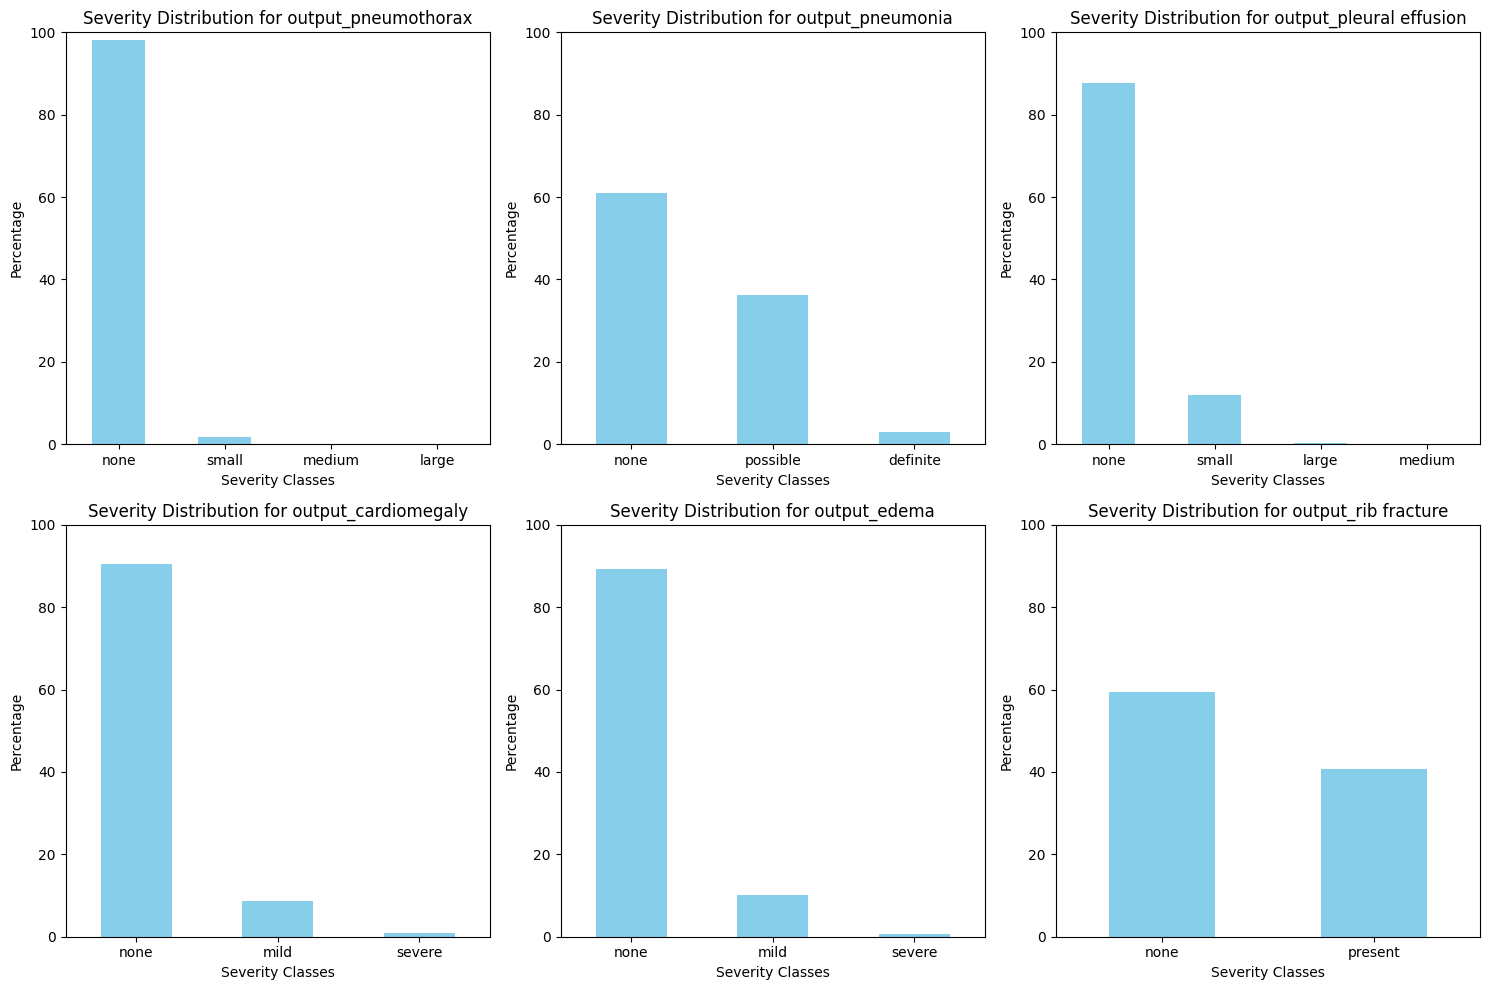

In [80]:
cols = [f'output_{key}' for key in keys]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(cols):
    value_counts_percentage = eval_df[col].value_counts(normalize=True) * 100

    value_counts_percentage.plot(kind='bar', ax=axs[i], color='skyblue')
    axs[i].set_title(f'Severity Distribution for {col}')
    axs[i].set_ylabel('Percentage')
    axs[i].set_xlabel('Severity Classes')
    axs[i].tick_params(axis='x', rotation=0)
    axs[i].set_ylim(0, 100)

plt.tight_layout()
plt.show()